In [1]:
import os
import gc
import time
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from sklearn.model_selection import GroupKFold
from sklearn.utils import shuffle
from multiprocessing import Pool
import lightgbm as lgb
from tqdm.notebook import tqdm
pd.set_option('display.max_columns', None)
try:
    print('available GPU devices:', len(os.environ['CUDA_VISIBLE_DEVICES']), 
          ' | device num:', os.environ['CUDA_VISIBLE_DEVICES'])
except:
    print('no environ cuda device variables')

no environ cuda device variables


In [2]:
SEED = 80
DATA_DIR = 'C:/data/m5/data_upd'
MODELS_DIR = 'C:/data/m5/models'
MODEL_VER = 'v10'
CUT_DATE = '2011-01-01'
END_D = 1941
PRED_FWD = 28
SHIFT_LCL = 28
N_CORES = int(psutil.cpu_count() * .75)
N_FOLDS = 6
print('num pf cores:', N_CORES)
#---|CUT_DATE|---train---|END_D - PRED_FWD|--val--|END_D|--forecast-->|END_D + PRED_FWD|
# v0 = basic 4 fold end_d 1941 --> 0.44737 oldLB
# v1 = basic 4 fold end_d 1913 --> 0.4771 and 0.4879 w/gr
# v2 = basic 3 fold end_d 1913 --> 0.48223
# v9 = basic score v1&6 4 folds gr regr (from 1/03) --> 0.48123 / 0.86866 no regr less .5 0.49432 / less .01
# v10 = as v1 but 6 folds --> 0.47785

num pf cores: 9


### LOAD AND PREPROCESS

In [3]:
CALENDAR_DTYPES = {
    'date':             'str',
    'wm_yr_wk':         'int16', 
    'weekday':          'object',
    'wday':             'int8', 
    'month':            'int8', 
    'year':             'int16', 
    'd':                'object',
    'event_name_1':     'object',
    'event_type_1':     'object',
    'event_name_2':     'object',
    'event_type_2':     'object',
    'snap_CA':          'int8', 
    'snap_TX':          'int8', 
    'snap_WI':          'int8'
}
PARSE_DATES = ['date']
SPRICES_DTYPES = {
    'store_id':    'object', 
    'item_id':     'object', 
    'wm_yr_wk':    'int16',  
    'sell_price':  'float16'
}
DROP_COLS = ['id', 'sales', 'date', 'wm_yr_wk', 'weekday', 'wday']
CAT_COLS = [
    'item_id', 'dept_id', 'store_id', 'cat_id', 'state_id', 
    'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
    'snap_CA', 'snap_TX', 'snap_WI'
]

In [4]:
def get_df():
    start_time = time.time()
    print('-' * 10, 'BASE GRID', '-' * 10)
    strain = pd.read_csv('{}/sales_train_evaluation.csv'.format(DATA_DIR))
    print('read train:', strain.shape)
    for day in range(END_D + 1, END_D + PRED_FWD + 1):
        strain['d_{}'.format(day)] = np.nan
    strain = pd.melt(
        strain,
        id_vars = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id'],
        value_vars = [col for col in strain.columns if col.startswith('d_')],
        var_name = 'd',
        value_name = 'sales'
    )
    print('melted train:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)
    print('read calendar:', calendar.shape)
    strain = strain.merge(calendar, on='d', copy=False)
    strain.drop(columns=['month', 'year'], inplace=True)
    strain['d'] = strain['d'].apply(lambda x: int(x.replace('d_', '')))  
    print('calendar merge done:', strain.shape)
    strain['tm_d'] = strain['date'].dt.day.astype(np.int8)
    strain['tm_w'] = strain['date'].dt.week.astype(np.int8)
    strain['tm_m'] = strain['date'].dt.month.astype(np.int8)
    strain['tm_y'] = strain['date'].dt.year
    strain['tm_y'] = (strain['tm_y'] - strain['tm_y'].min()).astype(np.int8)
    strain['tm_wm'] = strain['tm_d'].apply(lambda x: np.ceil(x / 7)).astype(np.int8)
    strain['tm_dw'] = strain['date'].dt.dayofweek.astype(np.int8)
    strain['tm_w_end'] = (strain['tm_dw'] >= 5).astype(np.int8)
    print('date features done')
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    sprices = pd.read_csv('{}/sell_prices.csv'.format(DATA_DIR), dtype=SPRICES_DTYPES)
    print('read prices:', sprices.shape)
    release_df = sprices.groupby(['store_id', 'item_id'])['wm_yr_wk'].agg(['min']).reset_index()
    release_df.columns = ['store_id', 'item_id', 'release']
    strain = strain.merge(release_df, on=['store_id', 'item_id'], how='left')
    del release_df
    print('release feature done')
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    sprices['price_max'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('max')
    sprices['price_min'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('min')
    sprices['price_std'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('std')
    sprices['price_mean'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('mean')
    sprices['price_norm'] = sprices['sell_price'] / sprices['price_max']
    sprices['price_nunique'] = sprices.groupby(['store_id', 'item_id'])['sell_price'].transform('nunique')
    sprices['item_nunique'] = sprices.groupby(['store_id', 'sell_price'])['item_id'].transform('nunique')
    calendar_prices = calendar[['wm_yr_wk', 'month', 'year']]
    calendar_prices = calendar_prices.drop_duplicates(subset=['wm_yr_wk'])
    sprices = sprices.merge(calendar_prices[['wm_yr_wk', 'month', 'year']], on=['wm_yr_wk'], how='left')
    del calendar, calendar_prices
    sprices['price_momentum'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id']
    )['sell_price'].transform(lambda x: x.shift(1))
    sprices['price_variance_w'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'wm_yr_wk']
    )['sell_price'].transform('std')
    sprices['price_momentum_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('mean')
    sprices['price_variance_m'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'month']
    )['sell_price'].transform('std')
    sprices['price_momentum_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('mean')
    sprices['price_variance_y'] = sprices['sell_price'] / sprices.groupby(
        ['store_id', 'item_id', 'year']
    )['sell_price'].transform('std')
    strain = strain.merge(sprices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
    strain.drop(columns=['month', 'year'], inplace=True)
    del sprices
    print('prices features and merge done:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    for col in CAT_COLS:
        strain[col]= strain[col].astype('category')
        strain[col] = strain[col].cat.codes.astype('int16')
        strain[col] -= strain[col].min()
    print('cols to category done:', strain.shape)
    print('begin train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    strain = strain.loc[strain['date'] >= CUT_DATE]
    print('date cut train:', strain.shape)
    print('cut train date:', strain['date'].min())
    print('end train date:', strain['date'].max())
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    gc.collect()
    return strain

In [5]:
def make_features_adv(strain):
    start_time = time.time()
    print('-' * 10, 'ADVANCED FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    icols =  [
        ['cat_id'],
        ['dept_id'],
        ['item_id']
    ]
    cols = list(set([item for sublist in icols for item in sublist]))
    cols.extend(['d', 'sales'])
    df_temp = strain[cols].copy()
    df_temp.loc[df_temp['d'] > (END_D - PRED_FWD), 'sales'] = np.nan
    for col in icols:
        col_name = '_{}_'.format('_'.join(col))
        strain['enc{}mean'.format(col_name)] = df_temp.groupby(col)['sales'].transform('mean').astype(np.float16)
        strain['enc{}std'.format(col_name)] = df_temp.groupby(col)['sales'].transform('std').astype(np.float16)
    print('encoding done')
    del df_temp
    gc.collect()
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [6]:
def make_features_lag(strain):
    start_time = time.time()
    print('-' * 10, 'LAG AND ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = range(PRED_FWD, PRED_FWD + 14 + 1)
    lag_cols = ['lag_{}'.format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        strain[lag_col] = strain[['id', 'sales']].groupby(['id'])['sales'].shift(lag).astype(np.float16)
    print('lag sales done')
    for roll in [7, 14, 30, 60, 180]:
        roll_col = 'lag_{}_roll_mean_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).mean()
        ).astype(np.float16)
        roll_col = 'lag_{}_roll_std_{}'.format(PRED_FWD, roll)
        strain[roll_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
            lambda x: x.shift(PRED_FWD).rolling(roll).std()
        ).astype(np.float16)
    print('roll mean and std sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [7]:
def make_features_last_sales(strain):
    start_time = time.time()
    print('-' * 10, 'LAST SALES FEATURE', '-' * 10)
    print('in dataframe:', strain.shape)
    n_day = 1    
    last_sales = strain[['id', 'd', 'sales']].copy()
    last_sales['non_zero'] = (last_sales['sales'] > 0).astype(np.int8)
    last_sales['non_zero_lag'] = last_sales.groupby(['id'])['non_zero'].transform(
        lambda x: x.shift(n_day).rolling(2000, 1).sum()
    ).fillna(-1)
    df_temp = last_sales[['id', 'd', 'non_zero_lag']].drop_duplicates(subset=['id', 'non_zero_lag'])
    df_temp.columns = ['id', 'd_min', 'non_zero_lag']
    last_sales = last_sales.merge(df_temp, on=['id', 'non_zero_lag'], how='left')
    strain.loc[:, 'last_sale'] = (last_sales['d'] - last_sales['d_min']).astype(np.int16)
    del last_sales, df_temp
    gc.collect()
    print('last non zero sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [8]:
def make_features_win(strain):
    start_time = time.time()
    print('-' * 10, 'WIN ROLL FEATURES', '-' * 10)
    print('in dataframe:', strain.shape)
    lags = [1, 7, 14, 30]
    windows= [7, 14, 30, 60]
    for lag in lags:
        for wnd in windows:
            wnd_col = 'lag_{}_roll_mean_{}'.format(lag, wnd)
            strain[wnd_col] = strain[['id', 'sales']].groupby(['id'])['sales'].transform(
                lambda x: x.shift(lag).rolling(wnd).mean().astype(np.float16)
            )
    print('window roll mean sales done')
    print('out dataframe:', strain.shape)
    elapsed_time = time.time() - start_time
    print('time elapsed: {:.0f} min {:.0f} sec'.format(elapsed_time // 60, elapsed_time % 60))
    return strain

In [9]:
%%time
LOAD_DATA = True
if not LOAD_DATA:
    strain = get_df()
    strain = make_features_adv(strain)
    strain = make_features_lag(strain)
    strain = make_features_last_sales(strain)
    strain = make_features_win(strain)
    file_name = '{}/strain.pkl'.format(DATA_DIR)
    strain.to_pickle(file_name)
    print('saved to file:', file_name)
else:
    strain = pd.read_pickle('{}/strain.pkl'.format(DATA_DIR))
    print('loaded:', strain.shape)

loaded: (60034810, 89)
Wall time: 22.3 s


from 2011-01-29 00:00:00 to 2016-06-19 00:00:00


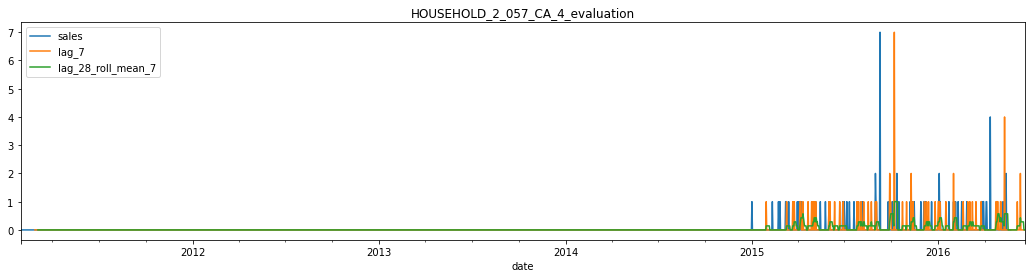

In [10]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[strain['id'] == id_name].set_index('date')
print('from', strain['date'].min(), 'to', strain['date'].max()) 
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales['lag_28'].plot(label='lag_7')
id_sales['lag_28_roll_mean_7'].plot(label='lag_28_roll_mean_7')
plt.title(id_name)
plt.legend()
plt.show()

In [11]:
train_cols = strain.columns[~strain.columns.isin(DROP_COLS)]
store_ids = list(strain['store_id'].unique())
print('stores:', store_ids)

stores: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### TRENDS

In [12]:
sales = pd.read_csv('{}/sales_train_evaluation.csv'.format(DATA_DIR))
calendar = pd.read_csv('{}/calendar.csv'.format(DATA_DIR), dtype=CALENDAR_DTYPES, parse_dates=PARSE_DATES)

In [13]:
sales = sales.groupby(['store_id']).sum()
d_cols = [c for c in sales.columns if 'd_' in c]
bystore_sales = sales[d_cols].T.merge(
    calendar[['d', 'date']],
    left_index=True,
    right_on=['d'],
    validate='1:1'
).set_index(['date'])
bystore_sales['d'] = bystore_sales['d'].apply(lambda x: int(x.replace('d_', '')))  

In [14]:
bystore_sales = bystore_sales.drop(
    index=[
        datetime(2011,12,25), 
        datetime(2012,12,25), 
        datetime(2013,12,25), 
        datetime(2014,12,25), 
        datetime(2015,12,25)
    ]
)
for col in bystore_sales.columns:
    bystore_sales[col + '_gr'] = bystore_sales[col].transform(lambda x: x.shift(1) / x)
bystore_sales = bystore_sales[bystore_sales.index >= datetime(2016, 3, 1)]

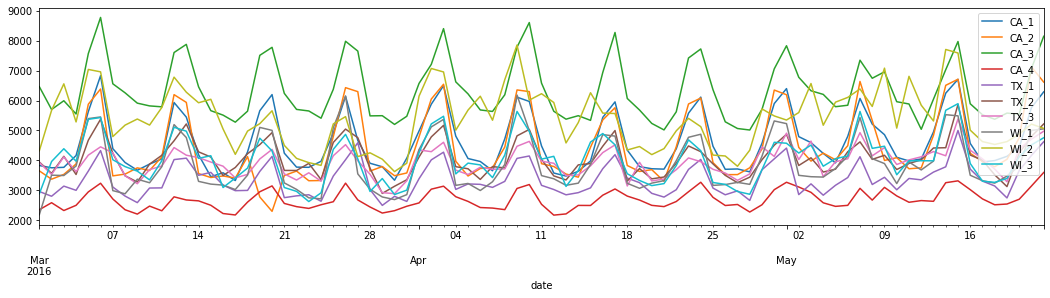

In [15]:
plt.figure(figsize=(18, 4))
for col in [x for x in bystore_sales.columns if ('_gr' not in x) and ('d' not in x)]:
    bystore_sales[col].plot(label=col)
plt.legend()
plt.show()

In [16]:
from sklearn.linear_model import LinearRegression

CA_1_gr [[-0.00021763]] [1.42486116] 0.9992899970228641
CA_2_gr [[-0.00036684]] [1.71842707] 1.001066634061398
CA_3_gr [[-0.00025271]] [1.48820813] 0.9940263743013882
CA_4_gr [[-0.00026634]] [1.50839906] 0.9875699835268016
TX_1_gr [[-0.00012887]] [1.25349098] 1.0014788701692232
TX_2_gr [[-0.00017542]] [1.34117711] 0.9981500629613382
TX_3_gr [[-3.24299281e-05]] [1.06616868] 1.0027519570064674
WI_1_gr [[-0.00056897]] [2.1060145] 0.993392872377588
WI_2_gr [[0.00021394]] [0.60618054] 1.024545029284978
WI_3_gr [[-5.936297e-05]] [1.12546933] 1.0093850373272417


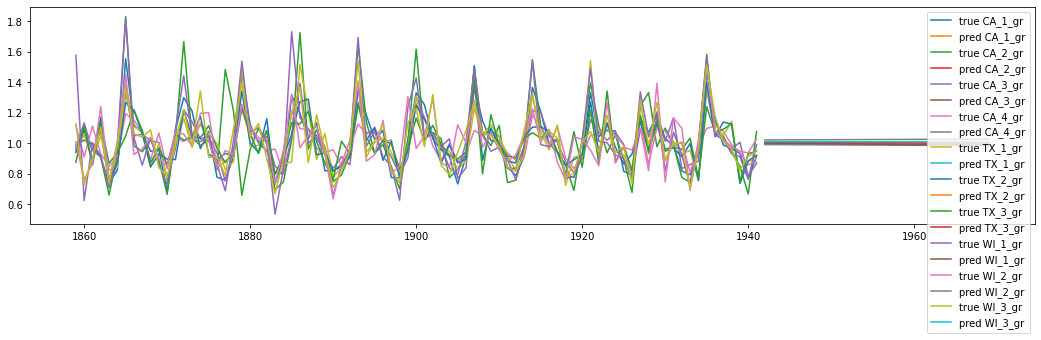

In [17]:
gr_dict = {}
plt.figure(figsize=(18, 4))
for i, col in enumerate([x for x in bystore_sales.columns if ('_gr' in x) and ('d' not in x)]):
    X = bystore_sales['d'].values.reshape(-1, 1)
    y = bystore_sales[col].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    X_pred = range(X[-1][0] + 1, X[-1][0] + PRED_FWD + 1)
    y_pred = reg.predict(np.array(X_pred).reshape(-1, 1)).reshape(-1)
    lbl = col
    plt.plot(bystore_sales['d'].values, bystore_sales[col].values, label='true {}'.format(lbl))
    plt.plot(X_pred, y_pred, label='pred {}'.format(lbl))
    gr_dict[i] = list(y_pred)
    print(col, reg.coef_, reg.intercept_, np.mean(y_pred))
plt.legend()
plt.show()
#CA_1 : small -
#CA_2 : +
#CA_3 : small -
#CA_4 : small +
#TX_1 : stable
#TX_2 : small +
#TX_3 : small +
#WI_1 : +
#WI_2 : ++
#WI_3 : +

In [18]:
print(len(gr_dict[0]))

28


### TRAINING

In [19]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'tweedie',
    'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': .5,
    'subsample_freq': 1,
    'learning_rate': .03,
    'num_leaves': 2 ** 11 - 1,
    'min_data_in_leaf': 2 ** 12 - 1,
    'feature_fraction': .5,
    'max_bin': 100,
    'n_estimators': 2000,
    'boost_from_average': False,
    'verbose': 1,
    'nthread': N_CORES,
    'early_stopping_rounds': 50,
    'lambda_l2': .1,
    'seed': SEED
}

In [20]:
for store_id in tqdm(store_ids):
    print('=' * 10, 'store training:', store_id, '=' * 10)
    strain_id = strain[(strain['d'] <= (END_D - SHIFT_LCL)) & (strain['store_id'] == store_id)].copy()
    strain_id['groups'] = strain_id['tm_w'].astype(str) + '_' + strain_id['tm_y'].astype(str)
    split_groups = strain_id['groups']
    folds = GroupKFold(n_splits=N_FOLDS)
    for fold_num, (trn_ids, val_ids) in enumerate(folds.split(strain_id, groups=split_groups)):
        print('-' * 10, 'fold training:', fold_num, '-' * 10)
        X_train = strain_id[train_cols].iloc[trn_ids]
        y_train = strain_id['sales'].iloc[trn_ids]
        X_val = strain_id[train_cols].iloc[val_ids]
        y_val = strain_id['sales'].iloc[val_ids]
        print('train shapes:', X_train.shape, len(y_train))
        print('val shapes:', X_val.shape, len(y_val))
        train_lgb = lgb.Dataset(X_train, label=y_train, categorical_feature=CAT_COLS, free_raw_data=False)
        val_lgb = lgb.Dataset(X_val, label=y_val, categorical_feature=CAT_COLS, free_raw_data=False)
        del X_train, y_train, X_val, y_val
        gc.collect()
        model = lgb.train(lgb_params, train_lgb, valid_sets=[val_lgb], verbose_eval=200) 
        model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
        model.save_model(model_file)
        print('save to file:', model_file)
    del strain_id, train_lgb, val_lgb
    gc.collect()

========== store training: 0 ==========
---------- fold training: 0 ----------
train shapes: (4857057, 83) 4857057
val shapes: (975680, 83) 975680


C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.14831
[400]	valid_0's rmse: 2.12257
[600]	valid_0's rmse: 2.1108
[800]	valid_0's rmse: 2.10413
[1000]	valid_0's rmse: 2.10033
[1200]	valid_0's rmse: 2.09863
[1400]	valid_0's rmse: 2.09689
Early stopping, best iteration is:
[1365]	valid_0's rmse: 2.09662
save to file: C:/data/m5/models/model_v10_store_0_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.30783
[400]	valid_0's rmse: 2.26299
[600]	valid_0's rmse: 2.2329
[800]	valid_0's rmse: 2.21075
[1000]	valid_0's rmse: 2.19921
[1200]	valid_0's rmse: 2.19194
[1400]	valid_0's rmse: 2.18551
Early stopping, best iteration is:
[1469]	valid_0's rmse: 2.18377
save to file: C:/data/m5/models/model_v10_store_0_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (96958

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.78062
[400]	valid_0's rmse: 1.76827
[600]	valid_0's rmse: 1.76303
[800]	valid_0's rmse: 1.76088
Early stopping, best iteration is:
[872]	valid_0's rmse: 1.76055
save to file: C:/data/m5/models/model_v10_store_1_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.78996
[400]	valid_0's rmse: 1.77141
[600]	valid_0's rmse: 1.75972
[800]	valid_0's rmse: 1.75413
[1000]	valid_0's rmse: 1.74943
[1200]	valid_0's rmse: 1.74689
[1400]	valid_0's rmse: 1.74575
Early stopping, best iteration is:
[1440]	valid_0's rmse: 1.74529
save to file: C:/data/m5/models/model_v10_store_1_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until validation scores don't improve for 50 rounds
[200]	valid_0's r

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 3.13159
[400]	valid_0's rmse: 3.04096
[600]	valid_0's rmse: 3.01119
[800]	valid_0's rmse: 2.99981
Early stopping, best iteration is:
[756]	valid_0's rmse: 2.99952
save to file: C:/data/m5/models/model_v10_store_2_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 3.35456
[400]	valid_0's rmse: 3.25683
[600]	valid_0's rmse: 3.17429
[800]	valid_0's rmse: 3.13492
[1000]	valid_0's rmse: 3.10734
[1200]	valid_0's rmse: 3.0957
[1400]	valid_0's rmse: 3.08558
Early stopping, best iteration is:
[1465]	valid_0's rmse: 3.08294
save to file: C:/data/m5/models/model_v10_store_2_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rm

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.35863
[400]	valid_0's rmse: 1.34702
[600]	valid_0's rmse: 1.34339
[800]	valid_0's rmse: 1.34177
[1000]	valid_0's rmse: 1.34097
[1200]	valid_0's rmse: 1.34055
Early stopping, best iteration is:
[1229]	valid_0's rmse: 1.3405
save to file: C:/data/m5/models/model_v10_store_3_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.32551
[400]	valid_0's rmse: 1.31091
[600]	valid_0's rmse: 1.30242
[800]	valid_0's rmse: 1.29735
[1000]	valid_0's rmse: 1.29425
[1200]	valid_0's rmse: 1.29219
[1400]	valid_0's rmse: 1.2913
Early stopping, best iteration is:
[1448]	valid_0's rmse: 1.29103
save to file: C:/data/m5/models/model_v10_store_3_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until va

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.90552
[400]	valid_0's rmse: 1.88866
[600]	valid_0's rmse: 1.88439
[800]	valid_0's rmse: 1.88159
Early stopping, best iteration is:
[928]	valid_0's rmse: 1.87909
save to file: C:/data/m5/models/model_v10_store_4_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.00856
[400]	valid_0's rmse: 1.9678
[600]	valid_0's rmse: 1.9458
[800]	valid_0's rmse: 1.93233
[1000]	valid_0's rmse: 1.92739
[1200]	valid_0's rmse: 1.92308
Early stopping, best iteration is:
[1195]	valid_0's rmse: 1.92222
save to file: C:/data/m5/models/model_v10_store_4_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.83767
[400]	valid_0's rmse

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.19012
[400]	valid_0's rmse: 2.15682
[600]	valid_0's rmse: 2.14733
[800]	valid_0's rmse: 2.14204
Early stopping, best iteration is:
[922]	valid_0's rmse: 2.14109
save to file: C:/data/m5/models/model_v10_store_5_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.12965
[400]	valid_0's rmse: 2.08228
[600]	valid_0's rmse: 2.05301
[800]	valid_0's rmse: 2.03892
[1000]	valid_0's rmse: 2.03075
Early stopping, best iteration is:
[1011]	valid_0's rmse: 2.03019
save to file: C:/data/m5/models/model_v10_store_5_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.30117
[400]	valid_0's rmse: 2.24173
[600]	valid_0's rms

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.86838
[400]	valid_0's rmse: 1.84059
[600]	valid_0's rmse: 1.82978
[800]	valid_0's rmse: 1.82622
Early stopping, best iteration is:
[935]	valid_0's rmse: 1.82356
save to file: C:/data/m5/models/model_v10_store_6_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.02873
[400]	valid_0's rmse: 1.95688
[600]	valid_0's rmse: 1.91264
[800]	valid_0's rmse: 1.89291
[1000]	valid_0's rmse: 1.8845
Early stopping, best iteration is:
[1107]	valid_0's rmse: 1.88136
save to file: C:/data/m5/models/model_v10_store_6_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.04529
[400]	valid_0's rmse: 1.99885
[600]	valid_0's rmse

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.42562
[400]	valid_0's rmse: 1.4134
[600]	valid_0's rmse: 1.40887
[800]	valid_0's rmse: 1.40651
[1000]	valid_0's rmse: 1.40478
[1200]	valid_0's rmse: 1.40358
[1400]	valid_0's rmse: 1.40277
Early stopping, best iteration is:
[1381]	valid_0's rmse: 1.40275
save to file: C:/data/m5/models/model_v10_store_7_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 1.54667
[400]	valid_0's rmse: 1.52509
[600]	valid_0's rmse: 1.51256
[800]	valid_0's rmse: 1.50486
[1000]	valid_0's rmse: 1.50015
[1200]	valid_0's rmse: 1.49664
[1400]	valid_0's rmse: 1.49472
Early stopping, best iteration is:
[1526]	valid_0's rmse: 1.49352
save to file: C:/data/m5/models/model_v10_store_7_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (9695

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.19399
[400]	valid_0's rmse: 2.1795
[600]	valid_0's rmse: 2.17415
Early stopping, best iteration is:
[601]	valid_0's rmse: 2.17409
save to file: C:/data/m5/models/model_v10_store_8_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.3292
[400]	valid_0's rmse: 2.30221
[600]	valid_0's rmse: 2.28819
[800]	valid_0's rmse: 2.28181
Early stopping, best iteration is:
[840]	valid_0's rmse: 2.27927
save to file: C:/data/m5/models/model_v10_store_8_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.39361
[400]	valid_0's rmse: 2.364
[600]	valid_0's rmse: 2.35543
[800]	valid_0's rmse: 2.35117
Early stopping, best iter

C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\vgarshin\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.02312
[400]	valid_0's rmse: 1.9897
[600]	valid_0's rmse: 1.97524
[800]	valid_0's rmse: 1.96911
[1000]	valid_0's rmse: 1.96553
[1200]	valid_0's rmse: 1.96335
Early stopping, best iteration is:
[1189]	valid_0's rmse: 1.96311
save to file: C:/data/m5/models/model_v10_store_9_fold_0.lgb
---------- fold training: 1 ----------
train shapes: (4860106, 83) 4860106
val shapes: (972631, 83) 972631
Training until validation scores don't improve for 50 rounds
[200]	valid_0's rmse: 2.28535
[400]	valid_0's rmse: 2.20843
[600]	valid_0's rmse: 2.15034
[800]	valid_0's rmse: 2.12028
[1000]	valid_0's rmse: 2.10775
[1200]	valid_0's rmse: 2.10247
[1400]	valid_0's rmse: 2.09861
Early stopping, best iteration is:
[1468]	valid_0's rmse: 2.09679
save to file: C:/data/m5/models/model_v10_store_9_fold_1.lgb
---------- fold training: 2 ----------
train shapes: (4863155, 83) 4863155
val shapes: (969582, 83) 969582
Training until v

In [21]:
store_id = 0
feat_importances = []
for fold_num in range(N_FOLDS):
    model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
    model = lgb.Booster(model_file=model_file)
    feat_importances.append(model.feature_importance())
    print('done:', model_file)
feat_importances = sorted(
    [(f, v) for f, v in zip(train_cols, np.mean(feat_importances, axis=0))],
    key=lambda x: x[1],
    reverse=True
)

done: C:/data/m5/models/model_v10_store_0_fold_0.lgb
done: C:/data/m5/models/model_v10_store_0_fold_1.lgb
done: C:/data/m5/models/model_v10_store_0_fold_2.lgb
done: C:/data/m5/models/model_v10_store_0_fold_3.lgb
done: C:/data/m5/models/model_v10_store_0_fold_4.lgb
done: C:/data/m5/models/model_v10_store_0_fold_5.lgb


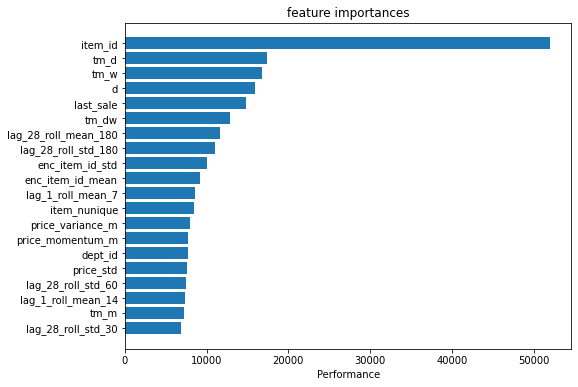

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))
labels, values = [x[0] for x in feat_importances[:20]], [x[1] for x in feat_importances[:20]]
y_pos = np.arange(len(labels))
ax.barh(y_pos, values)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel('Performance')
ax.set_title('feature importances')
plt.show()

In [23]:
%%time
spred = strain[
    (strain['d'] > (END_D - SHIFT_LCL - PRED_FWD)) &
    (strain['d'] <= (END_D - SHIFT_LCL)) &
    (strain['store_id'] == store_id)
].copy()
preds = []
for fold_num in range(N_FOLDS):
    model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
    model = lgb.Booster(model_file=model_file)
    preds.append(model.predict(spred[train_cols]))
    print('done:', model_file)
preds = np.mean(preds, axis=0)
print(len(preds))
spred.loc[:, 'sales'] = np.where(preds <= .1, 0, preds)

done: C:/data/m5/models/model_v10_store_0_fold_0.lgb
done: C:/data/m5/models/model_v10_store_0_fold_1.lgb
done: C:/data/m5/models/model_v10_store_0_fold_2.lgb
done: C:/data/m5/models/model_v10_store_0_fold_3.lgb
done: C:/data/m5/models/model_v10_store_0_fold_4.lgb
done: C:/data/m5/models/model_v10_store_0_fold_5.lgb
85372
Wall time: 1min 12s


id to draw: HOUSEHOLD_1_107_CA_1_evaluation


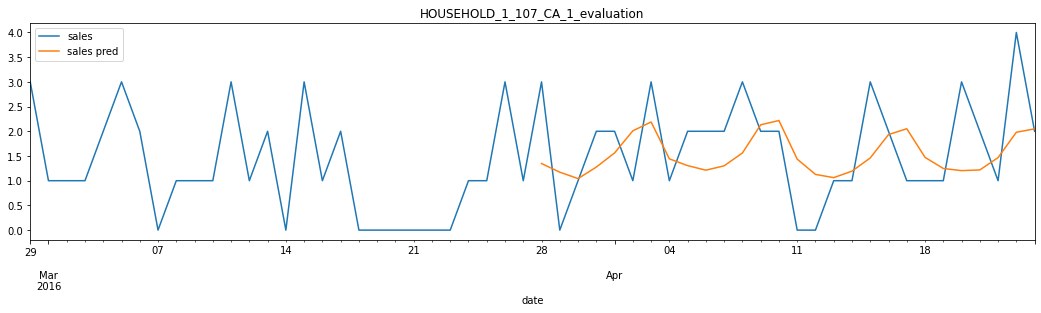

In [24]:
id_name = np.random.choice(strain[strain['store_id'] == store_id]['id'].unique())
print('id to draw:', id_name)
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - SHIFT_LCL - 2 * PRED_FWD)) &
    (strain['d'] <= (END_D - SHIFT_LCL)) &
    (strain['store_id'] == store_id)
].set_index('date')
id_sales_pred = spred.loc[spred['id'] == id_name].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales pred')
plt.title(id_name)
plt.legend()
plt.show()

### PREDICT

In [34]:
for pred_d in tqdm(range(1, PRED_FWD + 1)):
    print('=' * 10, 'forecast day forward:', pred_d, '=' * 10) 
    strain = make_features_last_sales(strain)
    spred = strain[strain['d'] > (END_D - SHIFT_LCL - 100)].copy()
    spred = make_features_win(spred)
    for store_id in store_ids:
        magic_rate = gr_dict[store_id][pred_d - 1]
        print('magic rate for store {} is {}'.format(store_id, magic_rate))
        preds = []
        for fold_num in range(N_FOLDS):
            model_file = '{}/model_{}_store_{}_fold_{}.lgb'.format(MODELS_DIR, MODEL_VER, store_id, fold_num)
            model = lgb.Booster(model_file=model_file)
            preds.append(
                model.predict(
                    spred.loc[
                        (spred['d'] == (END_D - SHIFT_LCL + pred_d)) & (spred['store_id'] == store_id), 
                        train_cols
                    ]
                )
            )
            print('store predicted:', store_id, '| model:', model_file)
        preds = np.mean(preds, axis=0)
        strain.loc[
            (strain['d'] == (END_D - SHIFT_LCL + pred_d)) & (strain['store_id'] == store_id), 
            'sales'
        ] = np.where(preds <= .1, 0, preds) #* magic_rate
    all_sales = strain[strain['d'] == (END_D - SHIFT_LCL + pred_d)]['sales'].values
    print('day forward:', END_D - SHIFT_LCL + pred_d, 'all sales:', np.sum(all_sales))

========== forecast day forward: 1 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 89)
last non zero sales done
out dataframe: (60034810, 89)
time elapsed: 1 min 30 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (4756440, 89)
window roll mean sales done
out dataframe: (4756440, 89)
time elapsed: 4 min 44 sec
magic rate for store 0 is 1.0022279723498304
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_0.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_1.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_2.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_3.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_4.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_5.lgb
magic rate for store 1 is 1.0060190073258761
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_0.lgb
store predicted: 1 | model: C:/data

store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_0.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_1.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_2.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_3.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_4.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_5.lgb
magic rate for store 6 is 1.0031573311078734
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_0.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_1.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_2.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_4.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_5.lgb
magic rate for store 7 is 1.000505002412974
store predi

store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_0.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_1.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_2.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_3.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_4.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_5.lgb
magic rate for store 1 is 1.00491847993377
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_0.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_1.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_2.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_3.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_4.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_5.lgb
magic rate for store 2 is 0.9966798687922225
store predic

store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_5.lgb
magic rate for store 6 is 1.003060041323536
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_0.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_1.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_2.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_4.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_5.lgb
magic rate for store 7 is 0.9987980912044814
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_0.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_1.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_2.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_4.lgb
store predi

store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_5.lgb
magic rate for store 1 is 1.0038179525416635
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_0.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_1.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_2.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_3.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_4.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_5.lgb
magic rate for store 2 is 0.995921727509127
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_0.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_1.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_2.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_3.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_4.lgb
store predi

store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_4.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_5.lgb
magic rate for store 7 is 0.9970911799959887
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_0.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_1.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_2.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_4.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_5.lgb
magic rate for store 8 is 1.023154403273075
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_0.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_1.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_2.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_3.lgb
store predi

store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_4.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_5.lgb
magic rate for store 2 is 0.9951635862260314
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_0.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_1.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_2.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_3.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_4.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_5.lgb
magic rate for store 3 is 0.9887685163030737
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_0.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_1.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_2.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_3.lgb
store pred

store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_4.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_5.lgb
magic rate for store 8 is 1.023796230663184
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_0.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_1.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_2.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_3.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_4.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_5.lgb
magic rate for store 9 is 1.0095928077223817
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_0.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_1.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_2.lgb
store predi

store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_3.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_4.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_5.lgb
magic rate for store 3 is 0.9879694944522255
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_0.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_1.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_2.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_3.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_4.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_5.lgb
magic rate for store 4 is 1.0016721804019455
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_0.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_1.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_2.lgb
store pred

store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_2.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_3.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_4.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_5.lgb
magic rate for store 9 is 1.0094147188122615
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_0.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_1.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_2.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_3.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_4.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_5.lgb
day forward: 1927 all sales: 46653.84476520139
========== forecast day forward: 15 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 89)
last non zero sales done
out dataframe: (

store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_2.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_3.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_4.lgb
store predicted: 3 | model: C:/data/m5/models/model_v10_store_3_fold_5.lgb
magic rate for store 4 is 1.0012855599365007
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_0.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_1.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_2.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_3.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_4.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_5.lgb
magic rate for store 5 is 0.9978869381480011
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_0.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_1.lgb
store pred

store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_1.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_2.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_3.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_4.lgb
store predicted: 9 | model: C:/data/m5/models/model_v10_store_9_fold_5.lgb
day forward: 1930 all sales: 40365.83355108955
========== forecast day forward: 18 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 89)
last non zero sales done
out dataframe: (60034810, 89)
time elapsed: 2 min 6 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (4756440, 89)
window roll mean sales done
out dataframe: (4756440, 89)
time elapsed: 7 min 13 sec
magic rate for store 0 is 0.9985282997158729
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_0.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_1.lgb
store predicted: 0 | model: C:/da

store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_1.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_2.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_3.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_4.lgb
store predicted: 4 | model: C:/data/m5/models/model_v10_store_4_fold_5.lgb
magic rate for store 5 is 0.9973606885213269
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_0.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_1.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_2.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_3.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_4.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_5.lgb
magic rate for store 6 is 1.002606022329961
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_0.lgb
store predi

day forward: 1933 all sales: 53867.26512080853
========== forecast day forward: 21 ==========
---------- LAST SALES FEATURE ----------
in dataframe: (60034810, 89)
last non zero sales done
out dataframe: (60034810, 89)
time elapsed: 2 min 6 sec
---------- WIN ROLL FEATURES ----------
in dataframe: (4756440, 89)
window roll mean sales done
out dataframe: (4756440, 89)
time elapsed: 7 min 12 sec
magic rate for store 0 is 0.9978754163098804
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_0.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_1.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_2.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_3.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_4.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_5.lgb
magic rate for store 1 is 0.9986821580451677
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1

magic rate for store 5 is 0.9968344388946527
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_0.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_1.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_2.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_3.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_4.lgb
store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_5.lgb
magic rate for store 6 is 1.0025087325456237
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_0.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_1.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_2.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_4.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_5.lgb
magic rate

store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_0.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_1.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_2.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_3.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_4.lgb
store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_5.lgb
magic rate for store 1 is 0.9975816306530614
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_0.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_1.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_2.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_3.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_4.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_5.lgb
magic rate for store 2 is 0.9916255935715854
store pred

store predicted: 5 | model: C:/data/m5/models/model_v10_store_5_fold_5.lgb
magic rate for store 6 is 1.0024114427612862
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_0.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_1.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_2.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_3.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_4.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_5.lgb
magic rate for store 7 is 0.9874186831478633
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_0.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_1.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_2.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_4.lgb
store pred

store predicted: 0 | model: C:/data/m5/models/model_v10_store_0_fold_5.lgb
magic rate for store 1 is 0.9964811032609551
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_0.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_1.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_2.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_3.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_4.lgb
store predicted: 1 | model: C:/data/m5/models/model_v10_store_1_fold_5.lgb
magic rate for store 2 is 0.9908674522884898
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_0.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_1.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_2.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_3.lgb
store predicted: 2 | model: C:/data/m5/models/model_v10_store_2_fold_4.lgb
store pred

store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_4.lgb
store predicted: 6 | model: C:/data/m5/models/model_v10_store_6_fold_5.lgb
magic rate for store 7 is 0.9857117719393704
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_0.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_1.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_2.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_3.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_4.lgb
store predicted: 7 | model: C:/data/m5/models/model_v10_store_7_fold_5.lgb
magic rate for store 8 is 1.0274332525404684
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_0.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_1.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_2.lgb
store predicted: 8 | model: C:/data/m5/models/model_v10_store_8_fold_3.lgb
store pred

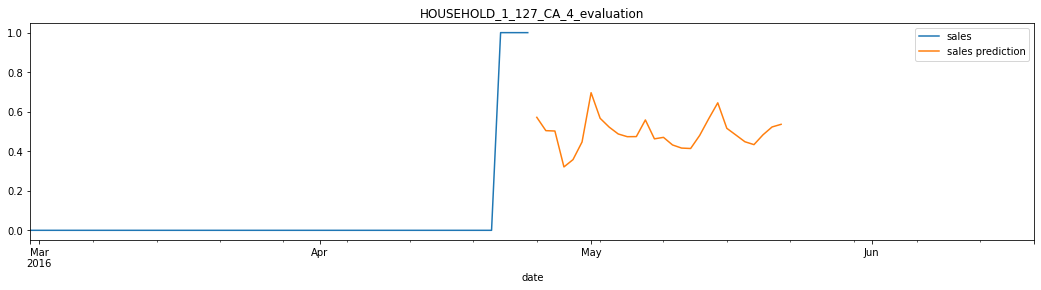

In [35]:
id_name = np.random.choice(strain['id'].unique())
id_sales = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - SHIFT_LCL - 2 * PRED_FWD)) &
    (strain['d'] <= (END_D - SHIFT_LCL))
].set_index('date')
id_sales_pred = strain.loc[
    (strain['id'] == id_name) & 
    (strain['d'] > (END_D - SHIFT_LCL))
].set_index('date')
plt.figure(figsize=(18, 4))
id_sales['sales'].plot(label='sales')
id_sales_pred['sales'].plot(label='sales prediction')
plt.title(id_name)
plt.legend()
plt.show()

In [36]:
spred_subm = strain.loc[strain['d'] > (END_D - SHIFT_LCL), ['id', 'd', 'sales']].copy()
spred_subm['d'] = spred_subm['d'].apply(lambda x: 'F{}'.format(x - (END_D - SHIFT_LCL)))
spred_subm.loc[spred_subm['sales'] < 0, 'sales'] = 0

In [37]:
f_cols = ['F{}'.format(x) for x in range(1, PRED_FWD + 1)]
spred_subm = spred_subm.set_index(['id', 'd']).unstack()['sales'][f_cols].reset_index()
spred_subm.fillna(0, inplace=True)
spred_subm.sort_values('id', inplace=True)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.head()

d,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.817247,0.726136,0.698974,0.722813,0.966894,0.972863,1.049889,0.860444,0.806355,0.816753,0.771465,0.985085,1.033044,0.868228,0.883933,0.754483,0.785738,0.759526,0.868403,0.973852,0.931157,0.754432,0.694454,0.683649,0.647447,0.776300,0.957073,0.856543
1,FOODS_1_001_CA_2_evaluation,1.136838,1.159552,1.078540,1.052291,1.203182,1.605164,1.811970,1.105501,1.206009,1.104625,1.155634,1.238728,1.566870,1.298891,1.081795,1.066672,1.127089,1.094638,1.266481,1.487169,1.547752,1.033500,1.091102,1.023811,1.014897,1.065466,1.393496,1.502537
2,FOODS_1_001_CA_3_evaluation,0.976137,1.110398,1.028784,0.999469,1.181878,1.565387,1.673624,0.970737,0.961632,0.934971,0.963318,1.123370,1.494250,1.349125,0.966468,0.950091,0.921105,0.876822,1.088113,1.394684,1.481518,0.964181,0.943772,0.978554,0.938888,1.106897,1.417487,1.560755
3,FOODS_1_001_CA_4_evaluation,0.344638,0.328834,0.307895,0.313654,0.331834,0.352827,0.359918,0.363298,0.342551,0.340136,0.358481,0.363563,0.400725,0.362262,0.388413,0.361372,0.357051,0.363848,0.363890,0.384425,0.381100,0.362302,0.334604,0.337268,0.339813,0.338659,0.381265,0.377718
4,FOODS_1_001_TX_1_evaluation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [38]:
spred_subm_val = spred_subm.copy()
spred_subm_val['id'] = spred_subm_val['id'].str.replace('evaluation', 'validation')
spred_subm = pd.concat([spred_subm_val, spred_subm], axis=0, sort=False)
spred_subm.reset_index(drop=True, inplace=True)
spred_subm.to_csv('{}/submission.csv'.format(DATA_DIR), index=False)
print('submission saved:', spred_subm.shape)

submission saved: (60980, 29)


### EVALUATE

In [39]:
class WRMSSEEvaluator(object):
    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()
        train_df['all_id'] = 0  # for lv1 aggregation
        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')].columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')].columns.tolist()
        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], axis=1, sort=False)
        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices
        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns
        weight_df = self.get_weight_df()
        self.group_ids = (
            'all_id',
            'cat_id',
            'state_id',
            'dept_id',
            'store_id',
            'item_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )
        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)[valid_target_columns].sum())
            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())
    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns].set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        weight_df = weight_df.loc[zip(self.train_df.item_id, self.train_df.store_id), :].reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns], weight_df], axis=1, sort=False)
        return weight_df
    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt)
    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape
        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)
        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds], axis=1, sort=False)
        group_ids = []
        all_scores = []
        for i, group_id in enumerate(self.group_ids):
            lv_scores = self.rmsse(valid_preds.groupby(group_id)[self.valid_target_columns].sum(), i + 1)
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, sort=False).prod(axis=1)
            group_ids.append(group_id)
            all_scores.append(lv_scores.sum())
        return group_ids, all_scores

In [40]:
df_train_full = pd.read_csv('{}/sales_train_evaluation.csv'.format(DATA_DIR))
df_calendar = pd.read_csv("{}/calendar.csv".format(DATA_DIR))
df_prices = pd.read_csv("{}/sell_prices.csv".format(DATA_DIR))
df_sample_submission = pd.read_csv("{}/sample_submission.csv".format(DATA_DIR))
df_sample_submission["order"] = range(df_sample_submission.shape[0])
df_train = df_train_full.iloc[:, :-28]
df_valid = df_train_full.iloc[:, -28:]
evaluator = WRMSSEEvaluator(df_train, df_valid, df_calendar, df_prices)

In [41]:
preds_valid = pd.read_csv("{}/submission.csv".format(DATA_DIR))
preds_valid = preds_valid[preds_valid.id.str.contains("validation")]
preds_valid = preds_valid.merge(
    df_sample_submission[["id", "order"]], 
    on="id"
).sort_values("order").drop(
    ["id", "order"], 
    axis=1
)
columns = {}
for i in range(PRED_FWD):
    columns['F{}'.format(i + 1)] = 'd_{}'.format(END_D - PRED_FWD + i + 1)
print(columns)
preds_valid.rename(columns=columns, inplace=True)
preds_valid.reset_index(inplace=True, drop=True)

{'F1': 'd_1914', 'F2': 'd_1915', 'F3': 'd_1916', 'F4': 'd_1917', 'F5': 'd_1918', 'F6': 'd_1919', 'F7': 'd_1920', 'F8': 'd_1921', 'F9': 'd_1922', 'F10': 'd_1923', 'F11': 'd_1924', 'F12': 'd_1925', 'F13': 'd_1926', 'F14': 'd_1927', 'F15': 'd_1928', 'F16': 'd_1929', 'F17': 'd_1930', 'F18': 'd_1931', 'F19': 'd_1932', 'F20': 'd_1933', 'F21': 'd_1934', 'F22': 'd_1935', 'F23': 'd_1936', 'F24': 'd_1937', 'F25': 'd_1938', 'F26': 'd_1939', 'F27': 'd_1940', 'F28': 'd_1941'}


In [42]:
groups, scores = evaluator.score(preds_valid)
score_public_lb = np.mean(scores)
for i in range(len(groups)):
    print(f"Score for group {groups[i]}: {round(scores[i], 5)}")
print(f"\nPublic LB Score: {round(score_public_lb, 5)}")

Score for group all_id: 0.22129
Score for group cat_id: 0.26392
Score for group state_id: 0.30278
Score for group dept_id: 0.35114
Score for group store_id: 0.38649
Score for group item_id: 0.79736
Score for group ['state_id', 'cat_id']: 0.35853
Score for group ['state_id', 'dept_id']: 0.43973
Score for group ['store_id', 'cat_id']: 0.44791
Score for group ['store_id', 'dept_id']: 0.53674
Score for group ['item_id', 'state_id']: 0.81113
Score for group ['item_id', 'store_id']: 0.81714

Public LB Score: 0.47785
